In [6]:
# !wget https://www.timeseriesclassification.com/Downloads/MotorImagery.zip
# !unzip MotorImagery.zip &> /dev/null
# !rm -rf *Dimension*

!wget https://www.bbci.de/competition/download/competition_iii/tuebingen/Competition_train.mat.gz
!wget https://www.bbci.de/competition/download/competition_iii/tuebingen/Competition_test.mat.gz
!wget https://bbci.de/competition/iii/results/tuebingen/true_labels.txt

!gzip -d Competition_train.mat.gz
!gzip -d Competition_test.mat.gz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

#getting the data from the mat file
df=scipy.io.loadmat('Competition_train.mat')
df2=scipy.io.loadmat('Competition_test.mat')
#here we can observe that matfile is loaded into dict file
#get the values from the X labels and Y labels 
X_train = df.get('X')
y_train = df.get('Y')
X_test = df2.get('X')
y_test = np.loadtxt('true_labels.txt')

y_train = np.where(y_train == 1, 0, 1)
y_test = np.where(y_test == 1, 0, 1)
!pip install mne

--2023-04-24 13:29:49--  https://www.bbci.de/competition/download/competition_iii/tuebingen/Competition_train.mat.gz
Resolving www.bbci.de (www.bbci.de)... 130.149.80.149
Connecting to www.bbci.de (www.bbci.de)|130.149.80.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122623595 (117M) [application/x-gzip]
Saving to: ‘Competition_train.mat.gz’

Competition_train.m 100%[===================>] 116.94M  27.3MB/s    in 5.0s    

2023-04-24 13:29:55 (23.4 MB/s) - ‘Competition_train.mat.gz’ saved [122623595/122623595]

--2023-04-24 13:29:55--  https://www.bbci.de/competition/download/competition_iii/tuebingen/Competition_test.mat.gz
Resolving www.bbci.de (www.bbci.de)... 130.149.80.149
Connecting to www.bbci.de (www.bbci.de)|130.149.80.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45068571 (43M) [application/x-gzip]
Saving to: ‘Competition_test.mat.gz’

Competition_test.ma 100%[===================>]  42.98M  20.5MB/s    in 2.1s    

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from scipy.io import arff
# from mne.io import RawArray
import pandas as pd
import matplotlib.pyplot as plt
# Set random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
%matplotlib inline

In [8]:
X_train_ = np.copy(X_train).reshape(278, 64, 3000)
y_train_ = np.ravel(np.copy(y_train))
X_test_ = np.copy(X_test).reshape(100, 64, 3000)
y_test_ = np.copy(y_test)

In [9]:
X_train_.shape, y_train_.shape, X_test_.shape, y_test_.shape

((278, 64, 3000), (278,), (100, 64, 3000), (100,))

In [15]:
X_all = np.concatenate((X_train_, X_test_), axis=0)

In [24]:
C = np.zeros((64, 378, 378))
for i in range(64):
    correlation_matrix = np.corrcoef(X_all[:, i, :])
    C[i] = correlation_matrix
    # break
C_avg = np.mean(C, axis=0)
C_avg.shape

(378, 378)

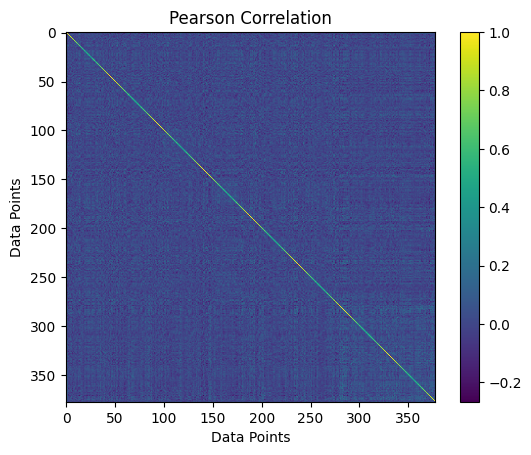

In [26]:

plt.imshow(C_avg)
plt.xlabel("Data Points")
plt.ylabel("Data Points")
plt.title("Pearson Correlation")
plt.colorbar()

In [29]:
similarity_arr = C_avg
simsig = np.std(similarity_arr)
simmean = np.mean(similarity_arr)

threshold = simmean + simsig

print(threshold)
threshold = 0.09 # Finetuned

0.09417292326085769


In [30]:
fcolors = []
for i in y:
    if i == 1:
        fcolors.append("red")
    else:
        fcolors.append("blue")

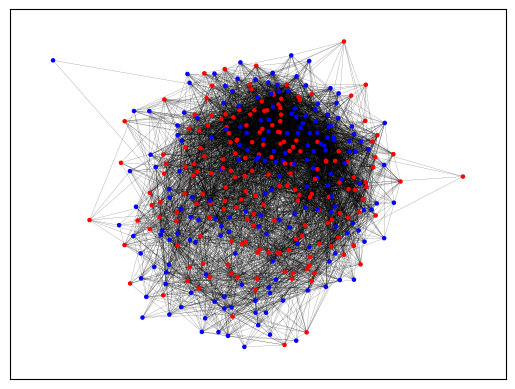

In [31]:
import networkx as nx

G = nx.Graph()

for i in range(378):
    G.add_node(i)
    
for i in range(378):
    for j in range(i+1,378):
        # if np.corrcoef(fdata[i],fdata[j])[0][1] > threshold:
        if C_avg[i, j] > threshold:
            G.add_edge(*(i,j))

nx.draw_networkx(G,pos=nx.spring_layout(G),node_size=5,with_labels=False,width=0.1,node_color=fcolors)
plt.savefig("eegnetwork.png",dpi=600)
plt.show()

In [64]:
print("Number of Edges: ", len(G.edges))
print("Number of Nodes: ", len(G.nodes))
print("Average Clustering Coeff.: ", nx.average_clustering(G))
print("Diamter : ", nx.diameter(G))
print("Sparsness: ", len(G.edges)/ 71253)

Number of Edges:  7381
Number of Nodes:  378
Average Clustering Coeff.:  0.3034491507353943
Diamter :  4
Sparsness:  0.10358862083000014


In [55]:
#getting the relations between the clustering coefficient, diameter,sparseness vs threshold
clstr_arr = []
d_arr = []
sparse_arr = []

t_arr =np.arange(0.001,0.5,0.005)

for threshold in t_arr:
    print(threshold)
    G = nx.Graph()

    for i in range(len(X_all)):
        G.add_node(i)

    for i in range(len(X_all)):
        for j in range(i+1,len(X_all)):
            if C_avg[i][j] > threshold:
                G.add_edge(*(i,j))
    
    clstr_arr.append(nx.average_clustering(G))
    
    G.to_undirected()
    connectcmpnt = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]
    if nx.is_connected(G)==True:
        D = nx.diameter(G)
    else:
        largestconnectcmpnt = G.subgraph(connectcmpnt)
        D = nx.diameter(largestconnectcmpnt)
    
    d_arr.append(D)
    
    S = len(G.edges())/71253 
    sparse_arr.append(S)

0.001
0.006
0.011
0.016
0.021
0.026000000000000002
0.031
0.036000000000000004
0.041
0.046
0.051000000000000004
0.056
0.061
0.066
0.07100000000000001
0.076
0.081
0.08600000000000001
0.091
0.096
0.101
0.106
0.111
0.116
0.121
0.126
0.131
0.136
0.14100000000000001
0.146
0.151
0.156
0.161
0.166
0.171
0.17600000000000002
0.181
0.186
0.191
0.196
0.201
0.20600000000000002
0.211
0.216
0.221
0.226
0.231
0.23600000000000002
0.241
0.246
0.251
0.256
0.261
0.266
0.271
0.276
0.281
0.28600000000000003
0.291
0.296
0.301
0.306
0.311
0.316
0.321
0.326
0.331
0.336
0.341
0.34600000000000003
0.35100000000000003
0.356
0.361
0.366
0.371
0.376
0.381
0.386
0.391
0.396
0.401
0.406
0.41100000000000003
0.41600000000000004
0.421
0.426
0.431
0.436
0.441
0.446
0.451
0.456
0.461
0.466
0.47100000000000003
0.47600000000000003
0.481
0.486
0.491
0.496


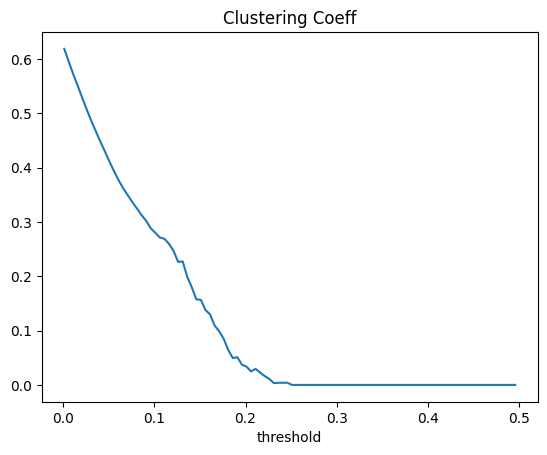

In [60]:
plt.title("Clustering Coeff")
plt.xlabel("threshold")
plt.plot(t_arr,clstr_arr)

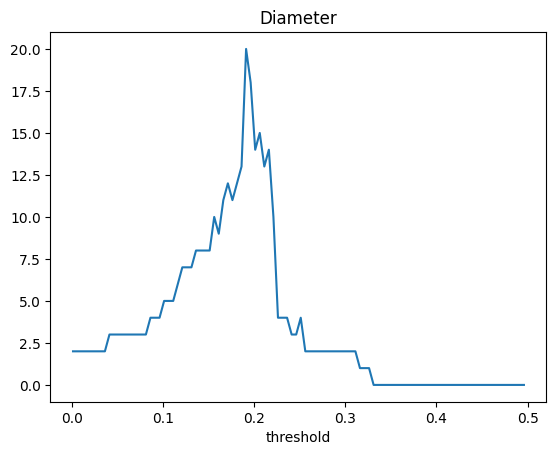

In [61]:
plt.title("Diameter")
plt.xlabel("threshold")
plt.plot(t_arr,d_arr)

Text(0.5, 0, 'threshold')

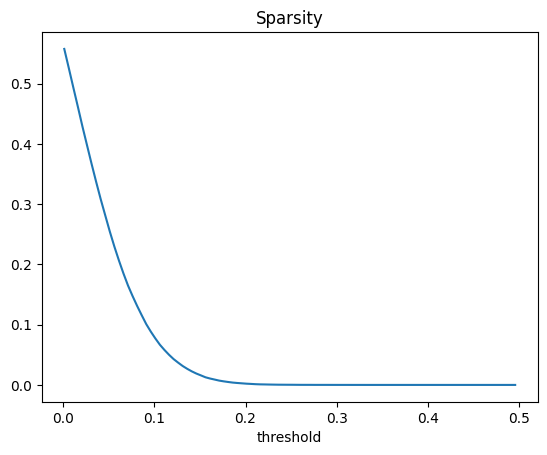

In [62]:
plt.plot(t_arr,sparse_arr)
plt.title("Sparsity")
plt.xlabel("threshold")

Sparseness :  0.10358862083000014
Average Clustering Coef.:  0.3034491507353943
Transitivity : 0.32523982871141277
Diameter :  4


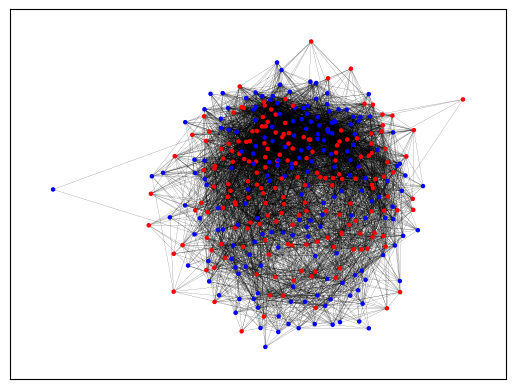

In [65]:

threshold = 0.09
G = nx.Graph()

for i in range(378):
    G.add_node(i)

for i in range(378):
    for j in range(i+1,378):
        if C_avg[i, j] > threshold:
            G.add_edge(*(i,j))
            
print("Sparseness : ",len(G.edges())/71253 )
print("Average Clustering Coef.: ", nx.average_clustering(G))
print("Transitivity :", nx.transitivity(G))
print("Diameter : ", nx.diameter(G))
nx.draw_networkx(G,pos=nx.spring_layout(G),node_size=5,with_labels=False,width=0.1,node_color=fcolors)
plt.show()

# Clustering

In [67]:
c = list(nx.community.greedy_modularity_communities(G,best_n = 2))

c1 = list(c[0])
c2 = list(c[1])

print(len(c1),len(c2))

196 182


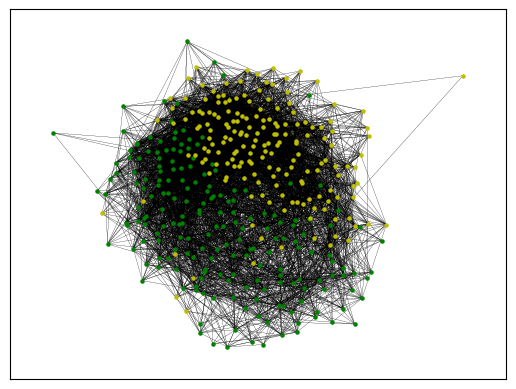

In [68]:
fclstrnodes = c1+c2

edge_list = list(G.edges())
G3= nx.Graph()
for n in fclstrnodes:
    G3.add_node(n)

for from_loc, to_loc in edge_list:
    G3.add_edge(from_loc, to_loc)

colors_c1 = [fcolors[i] for i in c1]
colors_c1 = [fcolors[i] for i in c2]


pos = nx.spring_layout(G3) 
nx.draw_networkx(G3, pos, nodelist=c1, node_color='g',node_size=5,with_labels=False,width=0.1)
nx.draw_networkx(G3, pos, nodelist=c2, node_color='y',node_size=5,with_labels=False,width=0.1)
plt.savefig("eegclustering.png",dpi =600)

plt.show()

In [69]:
nodes_c1 = []
nodes_c2 = []
for i in range(len(y)):
    if y[i] == 0:
        nodes_c1.append(i)
    else:
        nodes_c2.append(i)

In [77]:
print("Classificatoin rate: ", (len(set.intersection(set(c1),set(nodes_c1))) + len(set.intersection(set(c2),set(nodes_c2))))/378)

Classificatoin rate:  0.5264550264550265


In [74]:
mismatch = 0
for i in c1:
    if y[i] == 0:
        mismatch+=1
for i in c2:
    if y[i] == 1:
        mismatch += 1
print("Classification Rate :",mismatch / (len(c1) + len(c2)))

Classification Rate : 0.5264550264550265
